# PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle. EDA & ML

## 0. Описание кейса и постановка задачи

Представьте, что вы работаете дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, *которая предсказывает рейтинг отеля*. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Вы будете работать с датасетом, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель, которую вы будете обучать, должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. Изученные нами навыки разведывательного анализа помогут улучшить модель.

Первоначальная версия датасета содержит 17 полей со следующей информацией:

- hotel_address — адрес отеля;
- review_date — дата, когда рецензент разместил соответствующий отзыв;
- average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- hotel_name — название отеля;
- reviewer_nationality — страна рецензента;
- negative_review — отрицательный отзыв, который рецензент дал отелю;
- review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
- positive_review — положительный отзыв, который рецензент дал отелю;
- review_total_positive_word_counts — общее количество слов в положительном отзыве.
- reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
- total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
- total_number_of_reviews — общее количество действительных отзывов об отеле;
- tags — теги, которые рецензент дал отелю;
- days_since_review — количество дней между датой проверки и датой очистки;
- additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- lat — географическая широта отеля;
- lng — географическая долгота отеля.

## 1. Подготовка к работе

### 1.1. Импорт библиотек

In [20]:
import os
import pandas as pd
import numpy as np

# Загружаем специальный инструмент для разбивки данных:  
from sklearn.model_selection import train_test_split

# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
# инструменты для оценки точности модели
from sklearn import metrics

# библиотека для логирования эксперимента
from comet_ml import Experiment

# Библиотеки визуализации
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Установка параметров визуализации
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
sns.set_theme(style='darkgrid')

# Собственный модуль обработки данных
from eda import *

# Импорт переменных окружения
from decouple import config

# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

### 1.2. Эксперимент и константы

**Запуск эксперимента**

In [2]:
# Нужно ли логирование в Comet
save_experiment = False #config('SAVE_EXPERIMENT', default=False, cast=bool)

if save_experiment:
    experiment = Experiment(
        api_key=config('COMET_API',default=''),
        project_name='booking-reviews',
        workspace='mvulf'
    )

**Константы обучения**

In [3]:
TEST_SIZE = 0.25
RANDOM_STATE = 42
N_ESTIMATORS = 100
TARGET_NAME = 'reviewer_score'

if 'experiment' in locals():
    # Логируем применяемые параметры
    params = {
        'test_size': TEST_SIZE,
        'random_state': RANDOM_STATE,
        'n_estimators': N_ESTIMATORS,
        'target_name': TARGET_NAME
    }
    experiment.log_parameters(params)

### 1.3. Загрузка данных

In [4]:
# Загрузим данные для обучения
df_train = pd.read_csv('input/hotels_train.csv')
display(df_train.info())
df_train.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [5]:
# Загрузим тестовые данные
df_test = pd.read_csv('input/hotels_test.csv')
display(df_test.info())
df_test.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

None

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [6]:
# Загрузим файл для отправки на оценку
sample_submission = pd.read_csv('input/submission.csv')
display(sample_submission.info())
sample_submission.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


None

,reviewer_score,id
0,1,488440
1,10,274649


### 1.4. Объединение train и test

Объединение необходимо для совместной обработки двух датасетов

In [7]:
df_train['sample'] = 1 # пометили train
df_test['sample'] = 0 # пометили test
# в тесте у нас нет значения reviewer_score, мы его должны предсказать, 
# поэтому пока просто заполняем нулями
df_test['reviewer_score'] = 0

# Объединяем датасеты для работы
# первым идёт df_test, чтобы индексация совпала с submition
data = pd.concat([df_test, df_train]).reset_index(drop=True)

## 2. Понимание и Подготовка данных

Включает в себя:
- **Предварительный анализ данных (data understanding)** с составлением 
рекомендаций для предобработки признаков;
- **Предобработка данных и создание новых признаков 
(data preprocessing & feature generating)**. Реализация рекомендаций из 
предыдущенго пункта, дополнение внешними данными и создание новых признаков;
- **Очистку данных (data cleaning)**:
    - удаление/разметка дубликатов
    - заполнение пропусков
    - удаление/разметка выбросов и аномалий;

### Предварительный анализ данных (data understanding)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Посмотрим на количество уникальных значений

In [9]:
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

**Note**: 
- Явные пропуски содержатся в колонках долготы и широты местоположения 
отеля (lat & lng).
- В числовом формате данные хранятся в 9 из 16 столбцах.
- Для категориальных признаков будем вводить 'other' для редких значений 
с целью сокращения количества уникальных значений 

### Предобработка данных и создание новых признаков (data preprocessing & feature generating)

### Очистка данных (data cleaning)

Проводится: 
- удаление/разметка дубликатов;
- заполнение пропусков (при необходимости);
- удаление/разметка выбросов и аномалий

#### Дубликаты

#### Пропуски

#### Выбросы и аномалии

## 3. Разведывательный анализ данных (EDA)

Как правило, включает в себя:
- **Проверку статистических гипотез**.
Цель - сформировать корректное с точки зрения статистики представление о виде
неизвестного распределения генеральной совокупности,
о параметрах известных распределений или о статистической значимости разницы 
этих параметров при различных значениях независимой переменной;
- **Проектирование признаков (feature engineering)**:
    - *Создание новых признаков (feature generating)*. 
    Цель - создать более сильные признаки как из существующих данных, 
    так и из внешних источников; путём комбинации нескольких и т.д.
    - *Преобразование признаков (feature transformation)*.
    Цель - подготовить признаки для обучения и 
    повысить качество разрабатываемой модели:
        - Масштабирование, логарифмирование числовых признаков 
        (метод зависит от вида распределения [см. предыдущий пункт]);
        - Уменьшение числа уникальных значений;
        - Кодирование признаков (Ordered-, OneHot-, Binary- encoding).
        Для преобразования категориальные данные в формат, 
        пригодный для обучения - числовой;
- **Отбор признаков (feature selection)**. 
Цель - решение проблемы "проклятия размерности" и повышение качества 
разрабатываемой модели:
    - *выделить значимые признаки*, которые сильнее всего влияют на целевую 
    функцию (target) (оценка значимости признаков статистическими тестами - 
    feature importances);
    - *исключить мультиколлинеарные признаки*, сильно зависимые между собой;
    - *исключить неинформативные признаки*,
    когда большинство записей уникальны, либо наоборот, имеют одно значение.

### Создание новых признаков (feature generating)

Часть признаков была создана в разделе "2. Понимание и Подготовка данных".

### Преобразование признаков (feature transformation)
Масштабирование числовых, кодирование категориальных признаков и т.д.

### Отбор признаков
Для категориальных - хи-квадрат

Для непрерывных - ANOVA

### Решение-заглушка:

In [12]:
# убираем признаки, которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, 
# просто выберем их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

# заполняем пропуски самым простым способом
data = data.fillna(0)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 10 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
d

## 4. ML-Моделирование

**ОСНОВНЫЕ ЭТАПЫ:**
1. **Разделение набора данных:**
    - "по столбцам":
        - Признаки для обучения модели - **X**
        - Целевая переменная, которую будем предсказывать - **y**
    - "по строкам":
        - Тренировочный набор (**train**), для обучения модели
        - Тестовый набор (**test**), для оценки точности модели
2. **Создание, обучение модели (fit) и предсказание значений (predict)**
3. **Оценка качества модели**
    - с помощью метрик проверяется точность прогнозов, сделанных моделью.

### 4.1. Разделение набора данных

Вернёмся к двум первоначальным датасетам

In [14]:
# Датасет для обучения и оценки качества
df_train_test = data.query('sample == 1').drop('sample', axis=1)\
    .reset_index(drop=True)
# Датасет для финального предсказания целевой функции, которая не известна
df_predict = data.query('sample == 0').drop('sample', axis=1)

Разбиваем датасет для обучения и оценки качества модели - **df_train_test**

In [15]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)
X = df_train_test.drop([TARGET_NAME], axis=1)
y = df_train_test[TARGET_NAME]

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.
# Для тестирования мы будем использовать 25 % от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### 4.2. Создание и обучение модели

Примечание: 
- для корректной работы все данные в датафрейме, который используется при обучении модели, должны быть в числовых форматах int или float;
- в столбцах не должно быть пропущенных значений. Вместо каждого пропущенного значения вам нужно будет вычислить и поместить в ячейку максимально близкое к реальности значение.

In [16]:
# Создаём модель 
regr = RandomForestRegressor(n_estimators=N_ESTIMATORS)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred 
y_pred = regr.predict(X_test)

### 4.3. Оценка качества модели

In [22]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
train_mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', train_mape)
# Запишем показатели метрики
metrics_dict = {
    'train_mape': train_mape
}
if 'experiment' in locals():
    experiment.log_metrics(metrics_dict)

MAPE: 0.14133445135072734


<AxesSubplot:>

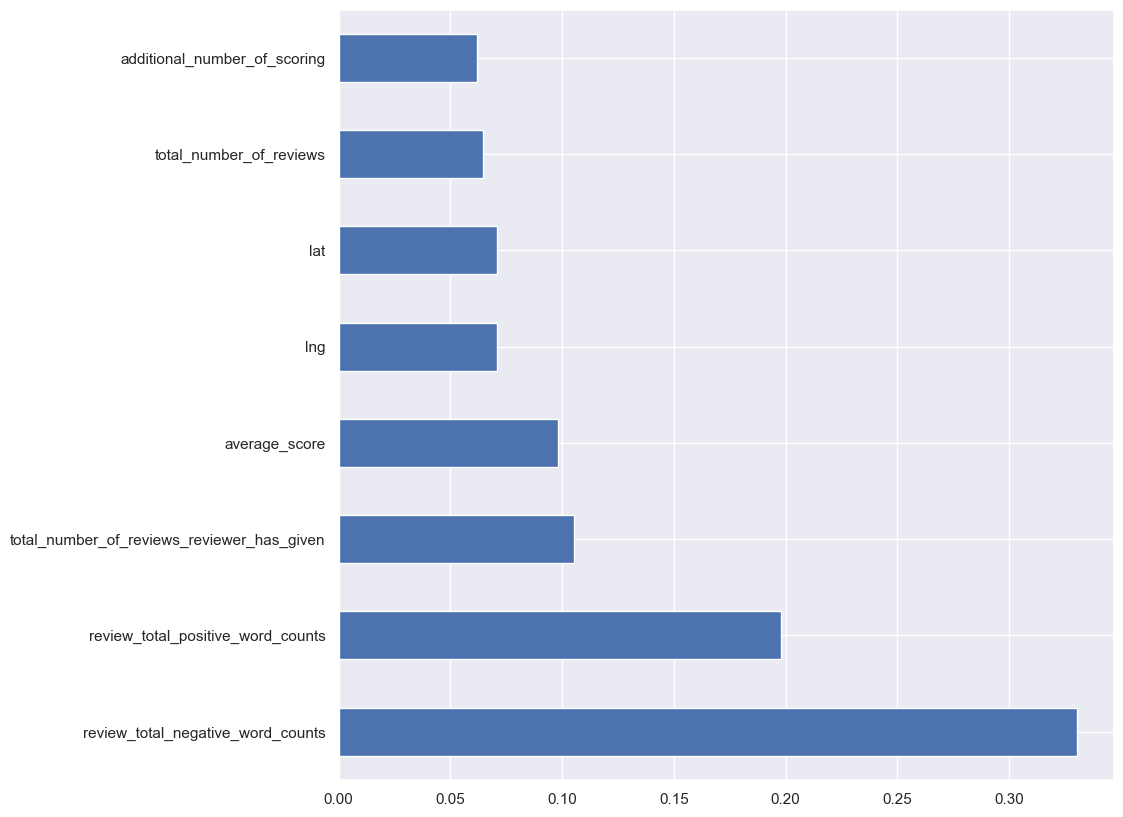

In [23]:
# выведем самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Завершение эксперимента

In [ ]:
if 'experiment' in locals():
    experiment.end()
    del experiment

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mvulf/booking-reviews/a994fe33ea2a458c8f5e13f766a710af
COMET INFO:   Metrics:
COMET INFO:     train_mape : 0.14143305160963474
COMET INFO:   Parameters:
COMET INFO:     n_estimators : 100
COMET INFO:     random_state : 42
COMET INFO:     target_name  : reviewer_score
COMET INFO:     test_size    : 0.25
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code          

### Финальное предсказание
С сохранением в файл submission.csv

In [19]:
# Предсказание
df_predict[TARGET_NAME] = regr.predict(df_predict.drop([TARGET_NAME], axis=1))
# Сохранение в датасет для отправки
sample_submission['reviewer_score'] = df_predict[TARGET_NAME]
# Экспорт
sample_submission.to_csv('output/submission.csv', index=False)

### Валидация
В реальных проектах должна проводиться проверка того, что построенная модель 
решает поставленные бизнес задачи; что нет проблем бизнеса, 
которые не были рассмотрены.

На вход поступает уже построенная модель с высокой используемой метрикой, 
полученной на шаге моделирования.

После этого возможно внедрение модели (Model Deployment)

## 5. Заключение

## *5. Валидация [ML-pipeline]*
Должна проводиться проверка того, что построенная модель решает поставленные бизнес задачи; что нет проблем бизнеса, которые не были рассмотрены.

На вход поступает уже построенная модель с высокой используемой метрикой, полученной на шаге моделирования.